# Exercise 10

In [38]:
!pip install tensorflow tensorflow-datasets -q
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## Load Dataset

In [39]:
ds, info = tfds.load(
    "speech_commands",
    with_info=True,
    as_supervised=True,
    split=["train", "test", "validation"]
)
train_ds, test_ds, val_ds = ds
print("Classes:", info.features["label"].names)

Classes: ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes', '_silence_', '_unknown_']


## Audio Preprocessing & Feature Extraction

In [40]:
SAMPLE_RATE = 16000
N_MFCC = 40
FRAME_LENGTH = 640
FRAME_STEP = 320
FFT_LENGTH = 1024
MAX_LEN = 98

def extract_mfcc(audio, label):
    audio = tf.cast(audio, tf.float32) / 32768.0

    # Short-time Fourier transform
    stft = tf.signal.stft(audio, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP, fft_length=FFT_LENGTH)
    spectrogram = tf.abs(stft)

    # Mel filterbank
    num_mel_bins = 64
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=num_mel_bins,
        num_spectrogram_bins=FFT_LENGTH // 2 + 1,
        sample_rate=SAMPLE_RATE,
        lower_edge_hertz=80,
        upper_edge_hertz=7600
    )
    mel_spectrogram = tf.tensordot(tf.square(spectrogram), mel_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate([num_mel_bins]))

    # Log-mel and MFCC
    log_mel = tf.math.log(mel_spectrogram + 1e-6)
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel)[..., :N_MFCC]

    # Pad/Truncate
    mfccs = mfccs[:MAX_LEN, :]
    paddings = [[0, MAX_LEN - tf.shape(mfccs)[0]], [0, 0]]
    mfccs = tf.pad(mfccs, paddings)
    mfccs = tf.expand_dims(mfccs, -1)  # (MAX_LEN, N_MFCC, 1)

    return mfccs, label

train_ds = train_ds.map(extract_mfcc).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(extract_mfcc).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(extract_mfcc).batch(32).prefetch(tf.data.AUTOTUNE)

#CNN Model

In [41]:
from tensorflow.keras import layers, models

cnn_model = models.Sequential([
    layers.Input(shape=(MAX_LEN, N_MFCC, 1)),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(info.features["label"].num_classes, activation="softmax")
])

cnn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
cnn_model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 96, 38, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 96, 38, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 48, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 46, 17, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 46, 17, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 23, 8, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,068 (113.55 KB)

 Trainable params: 28,876 (112.80 KB)

 Non-trainable params: 192 (768.00 B)

## Model CNN + GRU

In [42]:
input_layer = layers.Input(shape=(MAX_LEN, N_MFCC, 1))

x = layers.Conv2D(32, (3,3), activation="relu")(input_layer)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Reshape((x.shape[1], x.shape[2]*x.shape[3]))(x)
x = layers.GRU(64, return_sequences=False)(x)
x = layers.Dense(128, activation="relu")(x)
output = layers.Dense(info.features["label"].num_classes, activation="softmax")(x)

crnn_model = models.Model(inputs=input_layer, outputs=output)
crnn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
crnn_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 98, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 96, 38, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 48, 19, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 48, 608)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │       129,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,596 (545.30 KB)

 Trainable params: 139,596 (545.30 KB)

 Non-trainable params: 0 (0.00 B)

#Training Models

In [43]:
print("\n--- Training CNN ---")
history_cnn = cnn_model.fit(train_ds, validation_data=val_ds, epochs=10)
loss, acc = cnn_model.evaluate(test_ds)
print(f"CNN Test Accuracy: {acc:.4f}")

print("\n--- Training CRNN ---")
history_crnn = crnn_model.fit(train_ds, validation_data=val_ds, epochs=10)
loss, acc = crnn_model.evaluate(test_ds)
print(f"CRNN Test Accuracy: {acc:.4f}")


--- Training CNN ---
Epoch 1/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 130s 45ms/step - accuracy: 0.7053 - loss: 1.0463 - val_accuracy: 0.8415 - val_loss: 0.4662
Epoch 2/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 118s 38ms/step - accuracy: 0.8827 - loss: 0.3711 - val_accuracy: 0.8961 - val_loss: 0.3199
Epoch 3/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 113s 42ms/step - accuracy: 0.9076 - loss: 0.2941 - val_accuracy: 0.9009 - val_loss: 0.3097
Epoch 4/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 103s 38ms/step - accuracy: 0.9180 - loss: 0.2586 - val_accuracy: 0.9038 - val_loss: 0.2980
Epoch 5/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 113s 42ms/step - accuracy: 0.9239 - loss: 0.2374 - val_accuracy: 0.9045 - val_loss: 0.3044
Epoch 6/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 104s 38ms/step - accuracy: 0.9297 - loss: 0.2219 - val_accuracy: 0.9128 - val_loss: 0.3198
Epoch 7/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 104s 38ms/step - accuracy: 0.9314 - loss: 0.2102 - val_accuracy: 0.9160 - val_loss: 0.3463
Epoch 8/10
2673/2673 ━━━━━━━━━━━━━━━━━━━━ 103s 

## Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

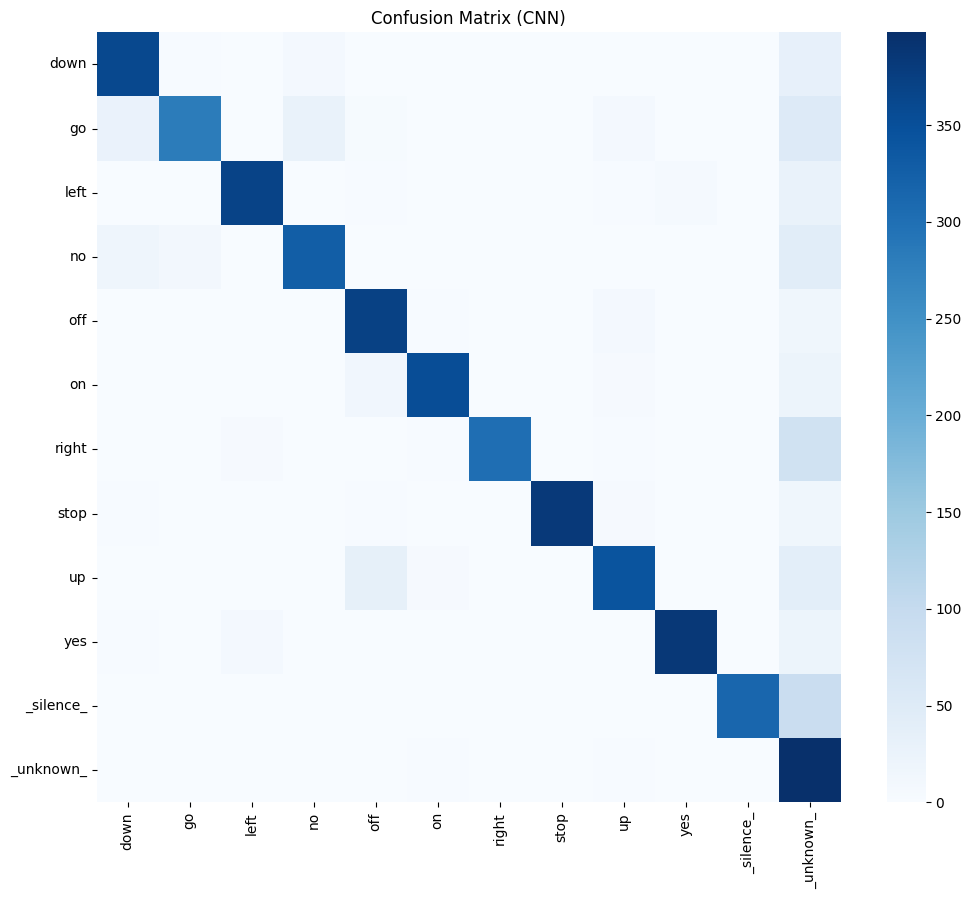


Classification Report (CNN):
              precision    recall  f1-score   support

        down       0.87      0.89      0.88       406
          go       0.95      0.70      0.81       402
        left       0.95      0.90      0.92       412
          no       0.89      0.81      0.85       405
         off       0.86      0.93      0.89       402
          on       0.96      0.89      0.93       396
       right       1.00      0.77      0.87       396
        stop       0.99      0.93      0.96       411
          up       0.91      0.81      0.85       425
         yes       0.98      0.92      0.95       419
   _silence_       1.00      0.77      0.87       408
   _unknown_       0.47      0.98      0.63       408

    accuracy                           0.86      4890
   macro avg       0.90      0.86      0.87      4890
weighted avg       0.90      0.86      0.87      4890

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

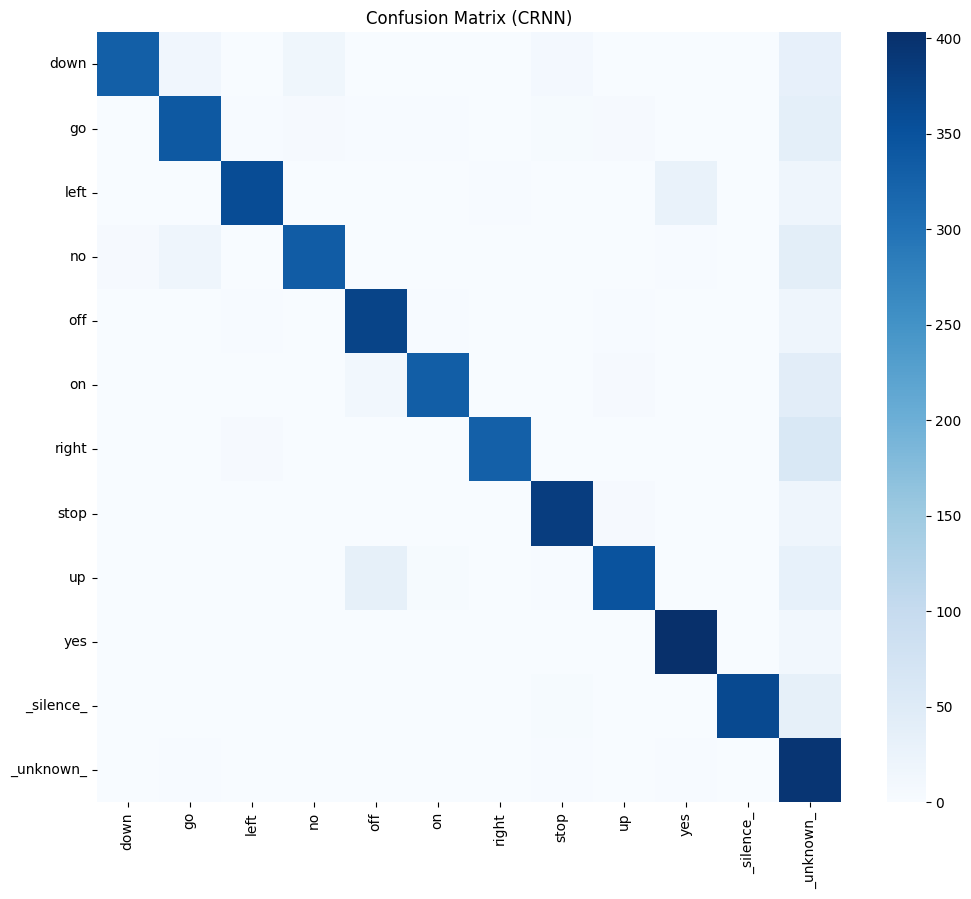


Classification Report (CRNN):
              precision    recall  f1-score   support

        down       0.97      0.81      0.89       406
          go       0.89      0.85      0.87       402
        left       0.97      0.87      0.92       412
          no       0.93      0.83      0.88       405
         off       0.87      0.93      0.90       402
          on       0.97      0.84      0.90       396
       right       0.99      0.83      0.91       396
        stop       0.94      0.93      0.93       411
          up       0.94      0.82      0.88       425
         yes       0.92      0.96      0.94       419
   _silence_       0.99      0.89      0.94       408
   _unknown_       0.52      0.97      0.68       408

    accuracy                           0.88      4890
   macro avg       0.91      0.88      0.88      4890
weighted avg       0.91      0.88      0.89      4890



In [44]:
def evaluate_model(model, test_ds, label_names, title="Model"):
    y_true, y_pred = [], []
    for x, y in test_ds:
        preds = model.predict(x)
        y_true.extend(y.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.title(f"Confusion Matrix ({title})")
    plt.show()

    print(f"\nClassification Report ({title}):")
    print(classification_report(y_true, y_pred, target_names=label_names))

# Evaluating both
evaluate_model(cnn_model, test_ds, info.features["label"].names, title="CNN")
evaluate_model(crnn_model, test_ds, info.features["label"].names, title="CRNN")